In [1]:
# v2: 1.102507841834652
# v9 : del area_floor
# 10: remove 1099
# 11: dayweek
# 12 : del bil_median
# 13 : leak data update
# 14 : site-0 unit correction
# sg filter

#v3 : add diff2 (bug)
#v4 : add diff2
#v5 : black 10
black_day = 10
outlier = False
rescale = False

debug=False
num_rounds = 200

clip0=False # minus meter confirmed in test(site0 leak data)

folds = 3 # 3, 6, 12
# 6: 1.1069822104487446
# 3: 1.102507841834652
# 12: 1.1074824417420517

use_ucf=False
ucf_clip=False

ucf_year = [2017, 2018] # ucf data year used in train 

predmode='all' # 'valid', train', 'all'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

In [3]:
os.listdir('/home/joydipb/Documents/CMT307-Coursework-2-Group-19')

['train_df_processed.feather',
 '.pytest_cache',
 'RF Model.py',
 'Modelling_CNN_Autoencoder.py',
 'building_metadata.csv',
 'ashrae-energy-prediction.zip',
 'Literature Review.docx',
 '.vscode',
 'test.feather',
 'sample_submission.feather',
 'ML_Intro.docx',
 'A Machine Learning Framework for Energy Consumption Prediction.pdf',
 'weather_train.csv',
 'README.md',
 'weather_test.feather',
 'Bourhnane2020_Article_MachineLearningForEnergyConsum.pdf',
 'train.csv',
 'building_metadata.feather',
 'Energy_Prediction_EDA_revised1.ipynb',
 'train.feather',
 '.git',
 'Energy_Consumption_Prediction_Using_Deep_Learning_.pdf',
 'weather_test.csv',
 'Processing_Energy_Prediction_Data.py',
 'API_integration.ipynb',
 'weather_train.feather',
 'sample_submission.csv',
 'ML_techniques_in_the_energy_consumption.pdf',
 'Postprocessed_Data_Energy_Prediction.py',
 'test.csv']

In [4]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
zone_dict={0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 

def set_local(df):
    for sid, zone in zone_dict.items():
        sids = df.site_id == sid
        df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)

In [6]:
! ls '/home/joydipb/Documents/CMT307-Coursework-2-Group-19'

'A Machine Learning Framework for Energy Consumption Prediction.pdf'
 API_integration.ipynb
 ashrae-energy-prediction.zip
 Bourhnane2020_Article_MachineLearningForEnergyConsum.pdf
 building_metadata.csv
 building_metadata.feather
 Energy_Consumption_Prediction_Using_Deep_Learning_.pdf
 Energy_Prediction_EDA_revised1.ipynb
'Literature Review.docx'
 ML_Intro.docx
 ML_techniques_in_the_energy_consumption.pdf
 Modelling_CNN_Autoencoder.py
 Postprocessed_Data_Energy_Prediction.py
 Processing_Energy_Prediction_Data.py
 README.md
'RF Model.py'
 sample_submission.csv
 sample_submission.feather
 test.csv
 test.feather
 train.csv
 train_df_processed.feather
 train.feather
 weather_test.csv
 weather_test.feather
 weather_train.csv
 weather_train.feather


In [7]:
root = Path('/home/joydipb/Documents/CMT307-Coursework-2-Group-19')
train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

building_meta_df = building_meta_df.merge(train_df[['building_id','meter']].drop_duplicates(), on='building_id')

#Set group  (site-meter) for training models

building_meta_df['groupNum_train'] = building_meta_df['site_id'].astype('int')*10 + building_meta_df['meter'].astype('int')

building_meta_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,groupNum_train
0,0,0,Education,7432,2008.0,NaN,0,0
1,0,1,Education,2720,2004.0,NaN,0,0
2,0,2,Education,5376,1991.0,NaN,0,0
3,0,3,Education,23685,2002.0,NaN,0,0
4,0,4,Education,116607,1975.0,NaN,0,0
...,...,...,...,...,...,...,...,...
2375,15,1444,Entertainment/public assembly,19619,1914.0,NaN,0,150
2376,15,1445,Education,4298,NaN,NaN,0,150
2377,15,1446,Entertainment/public assembly,11265,1997.0,NaN,0,150
2378,15,1447,Lodging/residential,29775,2001.0,NaN,0,150


In [8]:
print('Shape of Train Data:',train_df.shape)
print('Shape of Building Data:', building_meta_df.shape)
print('Shape of Weather Train Data:', weather_train_df.shape)

Shape of Train Data: (20216100, 4)
Shape of Building Data: (2380, 8)
Shape of Weather Train Data: (139773, 9)


In [9]:
#remove buildings

train_df = train_df [ train_df['building_id'] != 1099 ]

building_meta_df['floor_area'] = building_meta_df.square_feet / building_meta_df.floor_count

In [10]:
print('Shape of Train Data:',train_df.shape)
print('Shape of Building Data:', building_meta_df.shape)
print('Shape of Weather Train Data:', weather_train_df.shape)

Shape of Train Data: (20198534, 4)
Shape of Building Data: (2380, 9)
Shape of Weather Train Data: (139773, 9)


In [11]:
# Site Specific Holiday

import holidays

en_holidays = holidays.England()
ir_holidays = holidays.Ireland()
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

def add_holiyday(df_weather):
    en_idx = df_weather.query('site_id == 1 or site_id == 5').index
    ir_idx = df_weather.query('site_id == 12').index
    ca_idx = df_weather.query('site_id == 7 or site_id == 11').index
    us_idx = df_weather.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

    df_weather['IsHoliday'] = 0
    df_weather.loc[en_idx, 'IsHoliday'] = df_weather.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df_weather.loc[ir_idx, 'IsHoliday'] = df_weather.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df_weather.loc[ca_idx, 'IsHoliday'] = df_weather.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df_weather.loc[us_idx, 'IsHoliday'] = df_weather.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

    holiday_idx = df_weather['IsHoliday'] != 0
    df_weather.loc[holiday_idx, 'IsHoliday'] = 1
    df_weather['IsHoliday'] = df_weather['IsHoliday'].astype(np.uint8)

In [12]:
set_local(weather_train_df)
add_holiyday(weather_train_df)

In [13]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0,0
1,0,2015-12-31 21:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5,0
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,0
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,0
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,1


In [14]:
# Threshold By Black day¶

# # Count zero streak
train_df_black = train_df.copy()
train_df_black = train_df_black.merge(building_meta_df, on=['building_id', 'meter'], how='left')
train_df_black = train_df_black.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

train_df_black['black_count']=0

for bid in train_df_black.building_id.unique():
    df = train_df_black[train_df_black.building_id==bid]
    for meter in df.meter.unique():
        dfm = df[df.meter == meter]
        b = (dfm.meter_reading == 0).astype(int)
        train_df_black.loc[(train_df_black.building_id==bid) & (train_df_black.meter == meter), 'black_count'] = b.groupby((~b.astype(bool)).cumsum()).cumsum()

<AxesSubplot:>

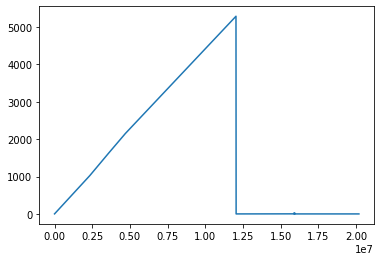

In [15]:
train_df_black[train_df_black.building_id == 954].black_count.plot()

In [16]:
train_df = train_df.merge(train_df_black[['timestamp','building_id','meter','black_count']], on=['timestamp','building_id','meter'])

In [17]:
train_df = train_df[train_df['black_count'] < 24*black_day].drop('black_count', axis=1)

In [18]:
train_df.shape

(19347775, 4)

In [19]:
del train_df_black
gc.collect()

18

In [20]:
## Removing weired data on site_id 0
#building_meta_df[building_meta_df.site_id == 0]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

<AxesSubplot:>

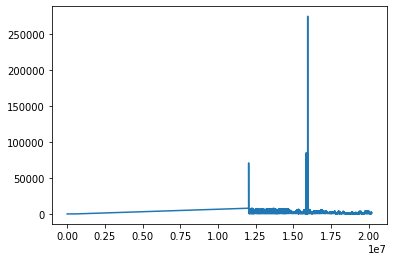

In [21]:
train_df[train_df.building_id == 954].meter_reading.plot()

<AxesSubplot:>

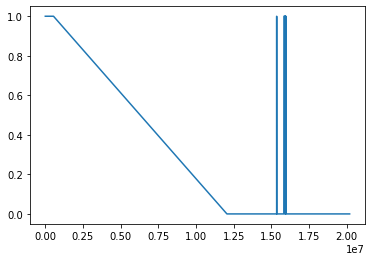

In [22]:
(train_df[train_df.building_id == 954].meter_reading==0).astype(int).plot()

<AxesSubplot:>

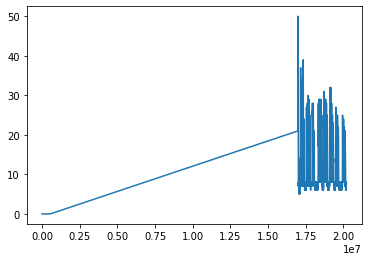

In [23]:
train_df[train_df.building_id == 1221].meter_reading.plot()

In [24]:
train_df = train_df.query('not (building_id == 954 & meter_reading == 0)')
train_df = train_df.query('not (building_id == 1221 & meter_reading == 0)')

<AxesSubplot:>

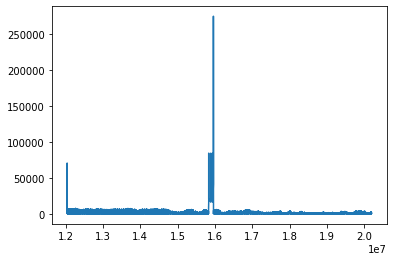

In [25]:
train_df[train_df.building_id == 954].meter_reading.plot()

<AxesSubplot:>

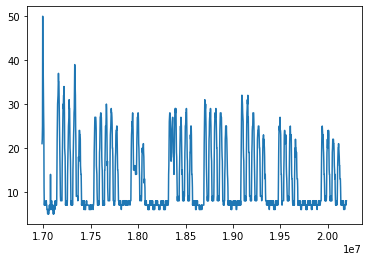

In [26]:
train_df[train_df.building_id == 1221].meter_reading.plot()

In [27]:
##Delete Outliear¶

funny_bids = [993, 1168,  904,  954,  778, 1021]

print ('before', len(train_df))

if outlier:
    #993
    # or delete
    train_df.loc[(train_df.building_id == 993) & (train_df.meter == 0) & (train_df.meter_reading > 30000), 'meter_reading'] = 31921
    train_df.loc[(train_df.building_id == 993) & (train_df.meter == 1) & (train_df.meter_reading > 90000), 'meter_reading'] =  96545.5

    #1168
    train_df = train_df[((train_df.building_id == 1168) & (train_df.meter == 0) & (train_df.meter_reading >10000)) == False]

    #904
    train_df.loc[(train_df.building_id == 904) & (train_df.meter == 0)& (train_df.meter_reading >10000), 'meter_reading'] = 11306

    #954
    train_df = train_df[((train_df.building_id == 954) & (train_df.meter_reading >10000))==False]

if rescale:
    #778 rescale ?
    train_df.loc[(train_df.building_id == 778) & (train_df.meter == 1), 'meter_reading'] = train_df.loc[(train_df.building_id == 778) & (train_df.meter == 1), 'meter_reading']/ 100
    #
    #1021 rescale ?
    train_df.loc[(train_df.building_id == 1021) & (train_df.meter == 3), 'meter_reading'] = train_df.loc[(train_df.building_id == 1021) & (train_df.meter == 3), 'meter_reading']/ 1000
    #plt.plot(np.log1p(train_df.loc[(train_df.building_id == 1021) & (train_df.meter == 3), 'meter_reading'] ))

train_df = train_df.reset_index()


print ('after', len(train_df))
gc.collect()

before 19237643
after 19237643


0

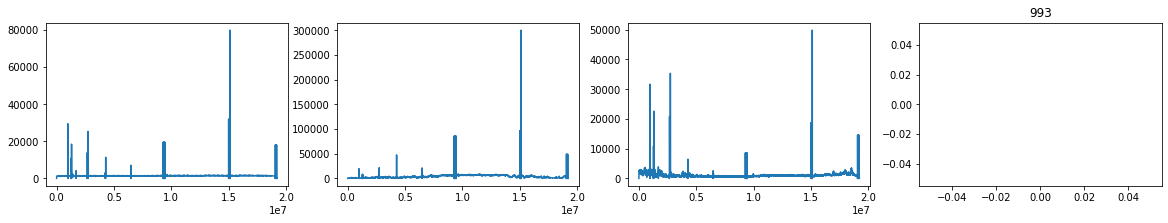

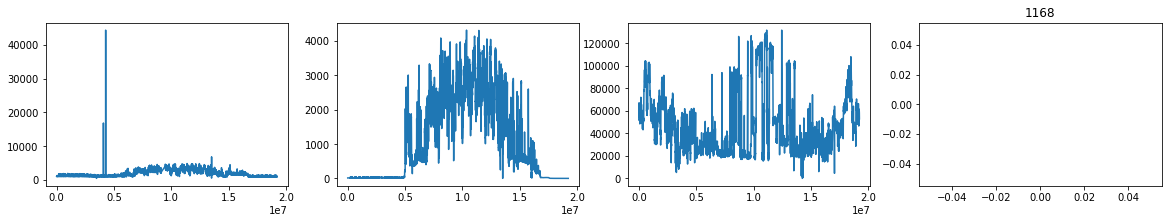

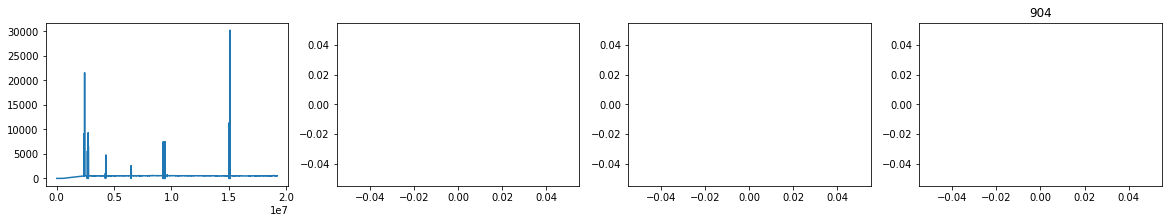

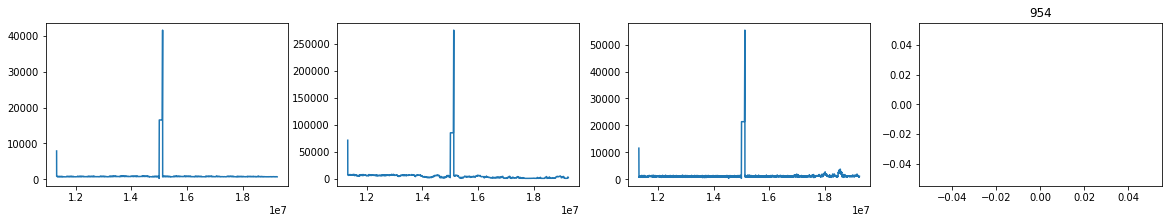

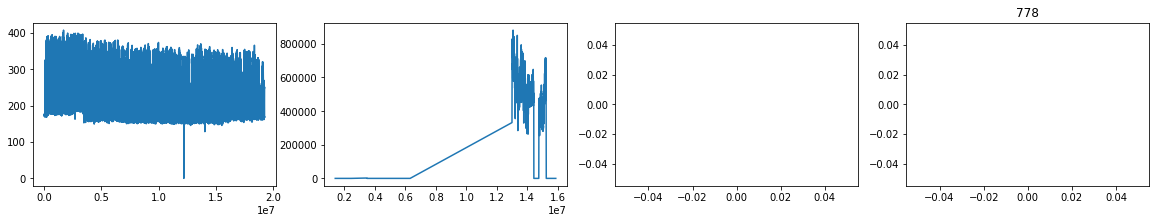

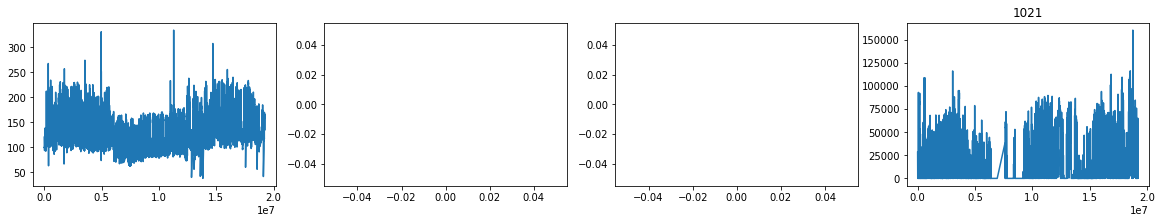

In [28]:
for bid in funny_bids:
    plt.figure(figsize=[20,3])
    plt.subplot(141)
    plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 0)].meter_reading)
    plt.subplot(142)
    plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 1)].meter_reading)
    plt.subplot(143)
    plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 2)].meter_reading)
    plt.subplot(144)
    plt.plot(train_df[(train_df.building_id == bid) & (train_df.meter == 3)].meter_reading)
    plt.title(bid)

In [29]:
## Site-0 Correction¶
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
site_0_bids = building_meta_df[building_meta_df.site_id == 0].building_id.unique()
print (len(site_0_bids), len(train_df[train_df.building_id.isin(site_0_bids)].building_id.unique()))
train_df[train_df.building_id.isin(site_0_bids) & (train_df.meter==0)].head(50)

105 105


,index,building_id,meter,timestamp,meter_reading
6927928,7530114,1,0,2016-05-20 01:00:00,0.0000
6927931,7530126,11,0,2016-05-20 01:00:00,0.0000
6927932,7530127,12,0,2016-05-20 01:00:00,0.0000
6927941,7530174,52,0,2016-05-20 01:00:00,0.0000
6927942,7530175,54,0,2016-05-20 01:00:00,0.0000
6927945,7530192,69,0,2016-05-20 01:00:00,0.0000
6927946,7530193,70,0,2016-05-20 01:00:00,0.0000
6927949,7530203,78,0,2016-05-20 01:00:00,0.0000
6927952,7530210,83,0,2016-05-20 01:00:00,0.0000
6927953,7530218,91,0,2016-05-20 01:00:00,0.0000


In [30]:
train_df.loc[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0), 'meter_reading'] = train_df[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0) ]['meter_reading'] * 0.2931

In [31]:
train_df[(train_df.building_id.isin(site_0_bids)) & (train_df.meter==0)].head(50)

,index,building_id,meter,timestamp,meter_reading
6927928,7530114,1,0,2016-05-20 01:00:00,0.000000
6927931,7530126,11,0,2016-05-20 01:00:00,0.000000
6927932,7530127,12,0,2016-05-20 01:00:00,0.000000
6927941,7530174,52,0,2016-05-20 01:00:00,0.000000
6927942,7530175,54,0,2016-05-20 01:00:00,0.000000
6927945,7530192,69,0,2016-05-20 01:00:00,0.000000
6927946,7530193,70,0,2016-05-20 01:00:00,0.000000
6927949,7530203,78,0,2016-05-20 01:00:00,0.000000
6927952,7530210,83,0,2016-05-20 01:00:00,0.000000
6927953,7530218,91,0,2016-05-20 01:00:00,0.000000


In [32]:
## Data preprocessing

train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

 # Add time feature¶
Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches
Features that are likely predictive:
Buildings:-
primary_use,
square_feet,
year_built,
floor_count (may be too sparse to use),
Weather,
time of day :-
holiday,
weekend,
cloud_coverage + lags,
dew_temperature + lags,
precip_depth + lags,
sea_level_pressure + lags,
wind_direction + lags,
wind_speed + lags,
Train:-
max, mean, min, std of the specific building historically,
number of meters,
number of buildings at a siteid.

In [33]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [34]:
preprocess(train_df)

In [35]:
## sort train
if use_ucf:
    train_df = train_df.sort_values('month')
    train_df = train_df.reset_index()

In [36]:
#df_group = train_df.groupby('building_id')['meter_reading_log1p']
#building_median = df_group.median().astype(np.float16)
#train_df['building_median'] = train_df['building_id'].map(building_median)

In [37]:
## Fill Nan value in weather dataframe by interpolation¶
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0,0
1,0,2015-12-31 21:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5,0
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,0
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,0
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,1


In [38]:
weather_train_df.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000,139773.000000
mean,7.478977,14.418107,2.149306,7.350158,0.983047,1016.158081,180.526627,3.560527,0.029398
std,4.604744,10.626595,2.599150,9.790235,8.463677,7.629684,111.523628,2.335874,0.168919
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200012,0.000000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.799988,80.000000,2.100000,0.000000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400024,190.000000,3.100000,0.000000
75%,11.000000,22.200001,4.000000,14.400000,0.000000,1020.799988,280.000000,5.000000,0.000000
max,15.000000,47.200001,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000,1.000000


In [39]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
IsHoliday                 0
dtype: int64

In [40]:
weather_train_df.shape

(139773, 10)

In [41]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
site_id,,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0,0
1,0,0,1,7062,1,8763,52,3,0,0
2,0,0,1,2354,1,66,44,591,5,0
3,0,0,4,3642,6,37,158,153,4,0
4,0,0,0,4230,2,1317,73,105,0,0
5,0,0,2,6030,2,8755,8755,295,3,0
6,0,0,10,2992,10,0,175,779,39,0
7,0,0,0,8614,23,7883,8,0,0,0
8,0,0,3,3830,3,1,85,250,0,0


In [42]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(method ='ffill', limit_direction ='forward'))
#weather_train_df.interpolate(method='ffill', axis=0, limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None)

In [43]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
site_id,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,8763,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,8,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0


In [44]:
## Adding some lag feature

def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [45]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [46]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0,0,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 21:00:00,24.400000,6.0,21.1,-1.0,1020.200012,70.0,1.5,0,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0,0,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0,0,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6,1,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [47]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'IsHoliday',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3',
       'sea_level_pressure_mean_lag3', 'sea_level_pressure_max_lag3',
       'sea_level_pressure_min_lag3', 'sea_level_pressure_std_lag3',
       'wind_direction_mean_lag3', 'wind_direction_max_lag3',
       'wind_direction_min_lag3', 'wind_direction_std_lag3',
       'wind_speed_mean_lag3', 'wind_

In [48]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
site_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,0,0,0,1,0,8763,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
5,0,0,0,0,0,8755,8755,0,0,0,...,8755,8755,0,0,0,1,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
7,0,0,0,8614,0,8,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
8,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [49]:
## count encoding

year_map = building_meta_df.year_built.value_counts()
building_meta_df['year_cnt'] = building_meta_df.year_built.map(year_map)

bid_map = train_df.building_id.value_counts()
train_df['bid_cnt'] = train_df.building_id.map(bid_map)

In [50]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [51]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building_meta_df = reduce_mem_usage(building_meta_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1522.76 MB
Memory usage after optimization is: 587.10 MB
Decreased by 61.4%
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.07 MB
Decreased by 40.6%
Memory usage of dataframe is 21.06 MB
Memory usage after optimization is: 19.33 MB
Decreased by 8.2%


In [52]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,groupNum_train,floor_area,year_cnt
0,0,0,0,7432,2008.0,NaN,0,0,NaN,6.0
1,0,1,0,2720,2004.0,NaN,0,0,NaN,20.0
2,0,2,0,5376,1991.0,NaN,0,0,NaN,6.0
3,0,3,0,23685,2002.0,NaN,0,0,NaN,13.0
4,0,4,0,116607,1975.0,NaN,0,0,NaN,23.0


In [53]:
print('Shape of Train Data:',train_df.shape)
print('Shape of Building Data:', building_meta_df.shape)
print('Shape of Weather Train Data:', weather_train_df.shape)

Shape of Train Data: (19237643, 13)
Shape of Building Data: (2380, 10)
Shape of Weather Train Data: (139773, 66)


In [54]:
## SG Filter for Weather

from scipy.signal import savgol_filter as sg

def add_sg(df):
    w = 11
    p = 2
    for si in df.site_id.unique():
        index = df.site_id == si
        df.loc[index, 'air_smooth'] = sg(df[index].air_temperature, w, p)
        df.loc[index, 'dew_smooth'] = sg(df[index].dew_temperature, w, p)
        
        df.loc[index, 'air_diff'] = sg(df[index].air_temperature, w, p, 1)
        df.loc[index, 'dew_diff'] = sg(df[index].dew_temperature, w, p, 1)
        
        df.loc[index, 'air_diff2'] = sg(df[index].air_temperature, w, p, 2)
        df.loc[index, 'dew_diff2'] = sg(df[index].dew_temperature, w, p, 2)

In [55]:
add_sg(weather_train_df)

<AxesSubplot:>

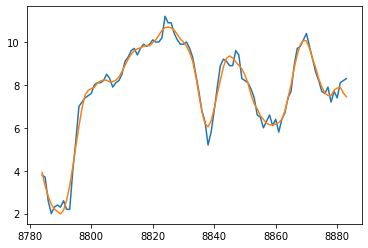

In [56]:
weather_train_df[weather_train_df.site_id==1].air_temperature[:100].plot()
weather_train_df[weather_train_df.site_id==1].air_smooth[:100].plot()

<AxesSubplot:>

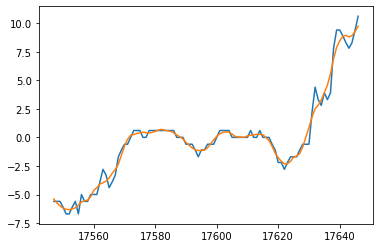

In [57]:
weather_train_df[weather_train_df.site_id==2].dew_temperature[:100].plot()
weather_train_df[weather_train_df.site_id==2].dew_smooth[:100].plot()

<AxesSubplot:>

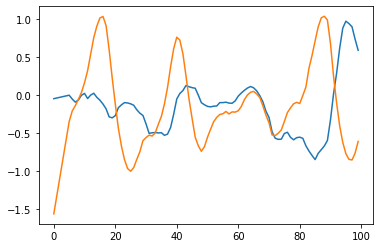

In [58]:
weather_train_df[weather_train_df.site_id==0].dew_diff[:100].plot()
weather_train_df[weather_train_df.site_id==0].air_diff[:100].plot()

## For time series data, it is better to consider time-splitting.
# However just to keep it simple, I am using K-fold cross validation

In [59]:
## Train Model 

category_cols = ['building_id', 'site_id', 'primary_use', 'IsHoliday', 'groupNum_train']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend',
#    'day', # 'month' ,
#    'dayofweek',
#    'building_median'
    ] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr',
    'sea_level_pressure',
#'wind_direction', 'wind_speed',
    'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72',
#'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 
    'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3',
    'sea_level_pressure_mean_lag3',
#    'wind_direction_mean_lag3', 'wind_speed_mean_lag3',
#    'floor_area',
    'year_cnt', 'bid_cnt',
    'dew_smooth', 'air_smooth',
    'dew_diff', 'air_diff',
    'dew_diff2', 'air_diff2'
] #+ list(df_groupNum_median.drop('timestamp',axis=1).columns)

In [60]:
train_df = train_df.merge(building_meta_df, on=['building_id','meter'], how='left')

In [61]:
train_df = reduce_mem_usage(train_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1064.11 MB
Memory usage after optimization is: 1064.11 MB
Decreased by 0.0%
Memory usage of dataframe is 25.73 MB
Memory usage after optimization is: 20.93 MB
Decreased by 18.7%


In [62]:
train_df = train_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

In [63]:
train_df = reduce_mem_usage(train_df, use_float16=True)

del weather_train_df
gc.collect()

Memory usage of dataframe is 3632.61 MB
Memory usage after optimization is: 3632.61 MB
Decreased by 0.0%


54

In [64]:
def create_X_y(train_df, groupNum_train):
    
    target_train_df = train_df[train_df['groupNum_train'] == groupNum_train].copy()        
    # target_train_df = target_train_df.merge(df_groupNum_median, on=['timestamp'], how='left')
    # target_train_df['group_median_'+str(groupNum_train)] = np.nan
    
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    
    del target_train_df
    return X_train, y_train

In [65]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 50

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [66]:
from sklearn.model_selection import GroupKFold, StratifiedKFold

seed = 666
shuffle = False
#kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
#kf = GroupKFold(n_splits=folds)
kf = StratifiedKFold(n_splits=folds)

## Train model by each group # (site-meter)

In [67]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model[1].feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

In [68]:
## Exporting Train Data to use in other models
train_df.to_feather('train_df_processed.feather')

groupNum_train 0 (559739, 38)
cat_features [33, 34, 35, 36, 37]
[ 5  6  7  8  9 11]
train 373159 valid 186580
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4418
[LightGBM] [Info] Number of data points in the train set: 373159, number of used features: 36
[LightGBM] [Info] Start training from score 4.082361
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.0958022	valid_1's l2: 0.195328
[100]	training's l2: 0.0603974	valid_1's l2: 0.169023
[150]	training's l2: 0.0458815	valid_1's l2: 0.159786
[200]	training's l2: 0.0395654	valid_1's l2: 0.157915
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0395654	valid_1's l2: 0.157915
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2

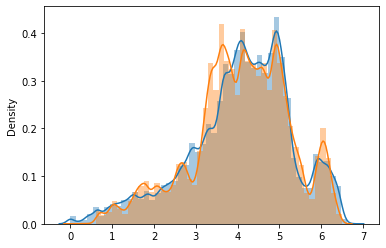

-------------------------------------------------------------
groupNum_train 1 (164279, 38)
cat_features [33, 34, 35, 36, 37]
[2 3 4 5 6 7 8]
train 109519 valid 54760
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 109519, number of used features: 36
[LightGBM] [Info] Start training from score 6.825479
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.32293	valid_1's l2: 2.48986
Early stopping, best iteration is:
[57]	training's l2: 1.22977	valid_1's l2: 2.48733
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.2297684462639082)]), 'valid_1': OrderedDict([('l2', 2.4873344001894546)])})
[ 5  6  7  8  9 10]
train 109519 valid 54760
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi

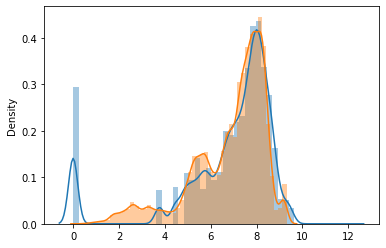

-------------------------------------------------------------
groupNum_train 10 (447982, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 298654 valid 149328
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4982
[LightGBM] [Info] Number of data points in the train set: 298654, number of used features: 33
[LightGBM] [Info] Start training from score 4.374910
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.124158	valid_1's l2: 0.43592
Early stopping, best iteration is:
[48]	training's l2: 0.129118	valid_1's l2: 0.433383
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.1291181882983825)]), 'valid_1': OrderedDict([('l2', 0.43338297588902086)])})
[5 6 7 8 9]
train 298655 valid 149327
trai

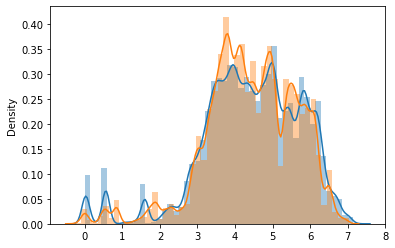

-------------------------------------------------------------
groupNum_train 13 (91387, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 60924 valid 30463
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4899
[LightGBM] [Info] Number of data points in the train set: 60924, number of used features: 33
[LightGBM] [Info] Start training from score 2.782155
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 2.03409	valid_1's l2: 2.10844
[100]	training's l2: 1.76155	valid_1's l2: 2.07365
Early stopping, best iteration is:
[81]	training's l2: 1.83761	valid_1's l2: 2.0689
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.8376093718550224)]), 'valid_1': OrderedDict([('l2', 2.0689023153446504)])})


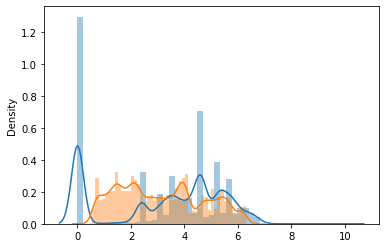

-------------------------------------------------------------
groupNum_train 20 (1181075, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 787383 valid 393692
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4563
[LightGBM] [Info] Number of data points in the train set: 787383, number of used features: 36
[LightGBM] [Info] Start training from score 4.269015
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.170594	valid_1's l2: 0.27911
[100]	training's l2: 0.12081	valid_1's l2: 0.259395
Early stopping, best iteration is:
[120]	training's l2: 0.106918	valid_1's l2: 0.256491
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.1069175811364234)]), 'valid_1': OrderedDict([('l2', 0.25649068456

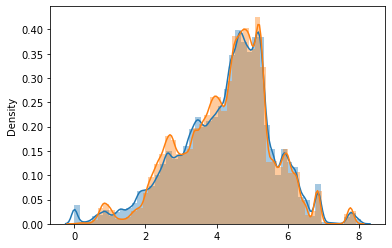

-------------------------------------------------------------
groupNum_train 21 (844854, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 563236 valid 281618
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4471
[LightGBM] [Info] Number of data points in the train set: 563236, number of used features: 36
[LightGBM] [Info] Start training from score 4.787236
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.76881	valid_1's l2: 1.26236
Early stopping, best iteration is:
[78]	training's l2: 0.651162	valid_1's l2: 1.22264
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.6511624024504422)]), 'valid_1': OrderedDict([('l2', 1.2226397006824299)])})
[ 3  4  5  6  7  8  9 10]
train 563236 va

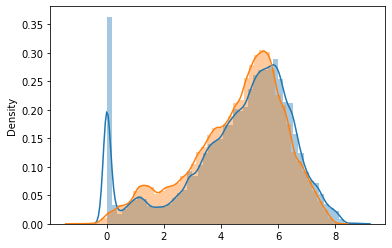

-------------------------------------------------------------
groupNum_train 23 (386956, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 257970 valid 128986
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4406
[LightGBM] [Info] Number of data points in the train set: 257970, number of used features: 36
[LightGBM] [Info] Start training from score 2.497047
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.591905	valid_1's l2: 1.1272
[100]	training's l2: 0.485709	valid_1's l2: 1.11773
Early stopping, best iteration is:
[98]	training's l2: 0.48817	valid_1's l2: 1.11609
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.488169896203224)]), 'valid_1': OrderedDict([('l2', 1.1160884798290853)])})
[ 1  2  3  4  5  6  7  8  9 10]
train 257971 valid 128985

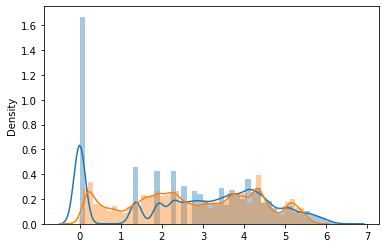

-------------------------------------------------------------
groupNum_train 30 (2370097, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8 12]
train 1580064 valid 790033
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4983
[LightGBM] [Info] Number of data points in the train set: 1580064, number of used features: 36
[LightGBM] [Info] Start training from score 3.882695
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.147833	valid_1's l2: 0.249856
[100]	training's l2: 0.102357	valid_1's l2: 0.222299
Early stopping, best iteration is:
[118]	training's l2: 0.0948654	valid_1's l2: 0.22106
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.09486537113695699)]), 'valid_1': OrderedDict

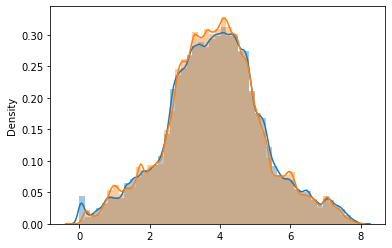

-------------------------------------------------------------
groupNum_train 40 (746700, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
train 497800 valid 248900
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4327
[LightGBM] [Info] Number of data points in the train set: 497800, number of used features: 36
[LightGBM] [Info] Start training from score 4.062337
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.074781	valid_1's l2: 0.0767307
[100]	training's l2: 0.0381915	valid_1's l2: 0.0519662
[150]	training's l2: 0.029784	valid_1's l2: 0.0483578
[200]	training's l2: 0.0262013	valid_1's l2: 0.0468102
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0262013	valid_1's l2: 0.0468102
best

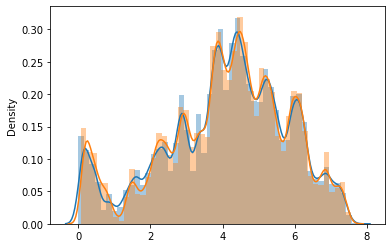

-------------------------------------------------------------
groupNum_train 50 (778919, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 519279 valid 259640
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3106
[LightGBM] [Info] Number of data points in the train set: 519279, number of used features: 30
[LightGBM] [Info] Start training from score 2.537773
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.372372	valid_1's l2: 0.460996
[100]	training's l2: 0.281409	valid_1's l2: 0.439901
Early stopping, best iteration is:
[107]	training's l2: 0.272917	valid_1's l2: 0.438043
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.2729170606829803)]), 'valid_1': OrderedDict([('l2', 0.438043

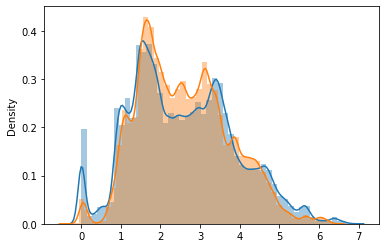

-------------------------------------------------------------
groupNum_train 60 (315436, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 210290 valid 105146
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4442
[LightGBM] [Info] Number of data points in the train set: 210290, number of used features: 34
[LightGBM] [Info] Start training from score 4.509502
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.0482919	valid_1's l2: 0.111951
[100]	training's l2: 0.0286433	valid_1's l2: 0.0931506
[150]	training's l2: 0.0224428	valid_1's l2: 0.0929614
Early stopping, best iteration is:
[135]	training's l2: 0.0239546	valid_1's l2: 0.0922226
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.0239

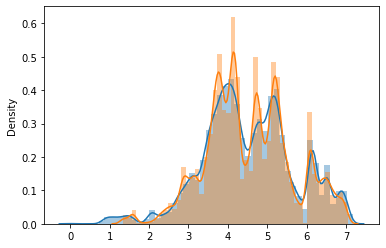

-------------------------------------------------------------
groupNum_train 62 (163168, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  9 10]
train 108778 valid 54390
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4475
[LightGBM] [Info] Number of data points in the train set: 108778, number of used features: 34
[LightGBM] [Info] Start training from score 4.271831
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.62839	valid_1's l2: 2.28583
[100]	training's l2: 1.27692	valid_1's l2: 2.16359
Early stopping, best iteration is:
[126]	training's l2: 1.19639	valid_1's l2: 2.13865
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.1963881273726853)]), 'valid_1': OrderedDict([('l2', 2.138651

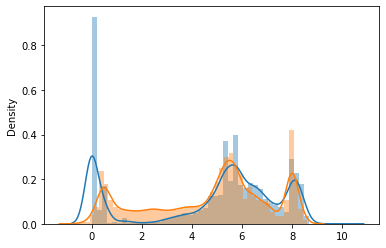

-------------------------------------------------------------
groupNum_train 61 (147831, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 98554 valid 49277
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4393
[LightGBM] [Info] Number of data points in the train set: 98554, number of used features: 34
[LightGBM] [Info] Start training from score 3.595227
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.16924	valid_1's l2: 2.36843
[100]	training's l2: 0.78087	valid_1's l2: 2.15969
[150]	training's l2: 0.651882	valid_1's l2: 2.11042
Early stopping, best iteration is:
[161]	training's l2: 0.62982	valid_1's l2: 2.10675
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.62981961559495)]), 

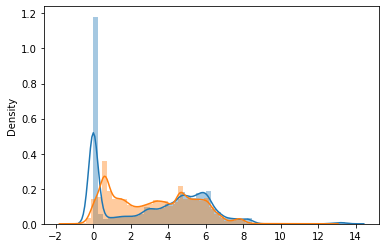

-------------------------------------------------------------
groupNum_train 71 (105217, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 70144 valid 35073
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5236
[LightGBM] [Info] Number of data points in the train set: 70144, number of used features: 32
[LightGBM] [Info] Start training from score 5.770184
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.873764	valid_1's l2: 2.61473
[100]	training's l2: 0.620708	valid_1's l2: 2.54878
Early stopping, best iteration is:
[92]	training's l2: 0.64353	valid_1's l2: 2.53932
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.6435302561483881)]), 'valid_1': OrderedDict([('l2', 2.53931604093288

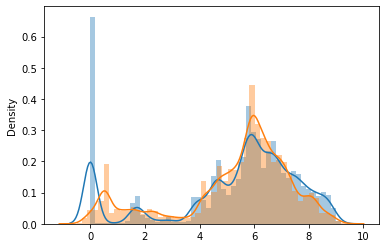

-------------------------------------------------------------
groupNum_train 72 (88558, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 59038 valid 29520
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5283
[LightGBM] [Info] Number of data points in the train set: 59038, number of used features: 32
[LightGBM] [Info] Start training from score 4.359065
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.45573	valid_1's l2: 1.40923
[100]	training's l2: 1.08074	valid_1's l2: 1.25604
Early stopping, best iteration is:
[100]	training's l2: 1.08074	valid_1's l2: 1.25604
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.0807359390146165)]), 'valid_1': OrderedDict([('l2', 1.256044490227404)])})

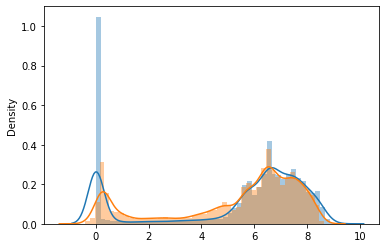

-------------------------------------------------------------
groupNum_train 70 (93979, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8 9]
train 62652 valid 31327
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5254
[LightGBM] [Info] Number of data points in the train set: 62652, number of used features: 32
[LightGBM] [Info] Start training from score 7.215099
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.113529	valid_1's l2: 2.72477
Early stopping, best iteration is:
[31]	training's l2: 0.214134	valid_1's l2: 2.70616
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.21413423494082282)]), 'valid_1': OrderedDict([('l2', 2.706157644028502)])})
[ 3  4  5  6  7  8  9 10 11]
train 62653

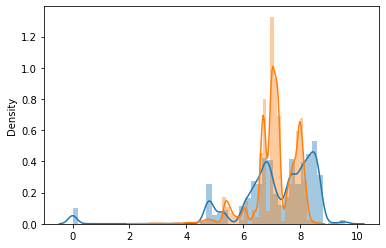

-------------------------------------------------------------
groupNum_train 73 (26137, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 17424 valid 8713
training LGB:
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5189
[LightGBM] [Info] Number of data points in the train set: 17424, number of used features: 32
[LightGBM] [Info] Start training from score 3.623467
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 2.52745	valid_1's l2: 1.71914
[100]	training's l2: 1.95202	valid_1's l2: 1.58293
Early stopping, best iteration is:
[84]	training's l2: 2.07871	valid_1's l2: 1.57532
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 2.07

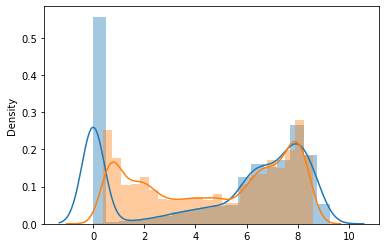

-------------------------------------------------------------
groupNum_train 80 (556808, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 371205 valid 185603
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4416
[LightGBM] [Info] Number of data points in the train set: 371205, number of used features: 34
[LightGBM] [Info] Start training from score 2.724100
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.223795	valid_1's l2: 0.296863
[100]	training's l2: 0.173201	valid_1's l2: 0.282394
Early stopping, best iteration is:
[89]	training's l2: 0.18063	valid_1's l2: 0.280402
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.18062971262420977)]), 'valid_1': OrderedDict([('l2', 0.280401796

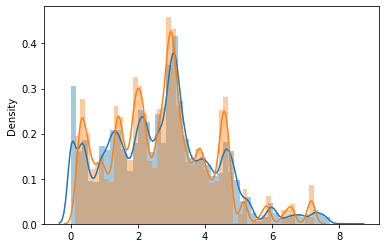

-------------------------------------------------------------
groupNum_train 90 (1053128, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8 9]
train 702085 valid 351043
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4581
[LightGBM] [Info] Number of data points in the train set: 702085, number of used features: 34
[LightGBM] [Info] Start training from score 4.425317
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.281719	valid_1's l2: 0.749134
[100]	training's l2: 0.112119	valid_1's l2: 0.732051
[150]	training's l2: 0.0713053	valid_1's l2: 0.72423
[200]	training's l2: 0.0549954	valid_1's l2: 0.723465
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.0549954	valid_1's l2: 0.723465
best_score defaultdict(<cla

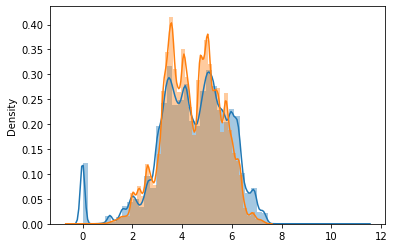

-------------------------------------------------------------
groupNum_train 91 (823947, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 8 9]
train 549298 valid 274649
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4509
[LightGBM] [Info] Number of data points in the train set: 549298, number of used features: 34
[LightGBM] [Info] Start training from score 5.536653
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.531731	valid_1's l2: 1.18871
[100]	training's l2: 0.316129	valid_1's l2: 1.13602
[150]	training's l2: 0.22706	valid_1's l2: 1.12564
[200]	training's l2: 0.186318	valid_1's l2: 1.11798
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.186318	valid_1's l2: 1.11798
best_score defaultdict(<class 'collect

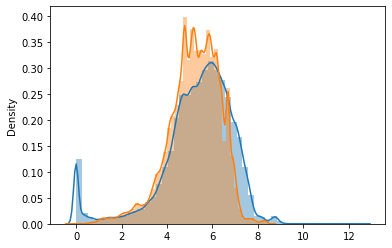

-------------------------------------------------------------
groupNum_train 92 (764056, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8 9]
train 509370 valid 254686
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4490
[LightGBM] [Info] Number of data points in the train set: 509370, number of used features: 34
[LightGBM] [Info] Start training from score 3.798978
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.16017	valid_1's l2: 1.53005
[100]	training's l2: 0.996857	valid_1's l2: 1.51284
Early stopping, best iteration is:
[91]	training's l2: 1.01608	valid_1's l2: 1.51166
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.016084570240902)]), 'valid_1': OrderedDict([('l2', 1.511659611

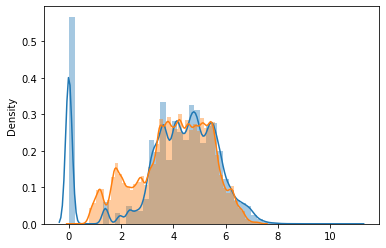

-------------------------------------------------------------
groupNum_train 100 (236573, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 7]
train 157715 valid 78858
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4514
[LightGBM] [Info] Number of data points in the train set: 157715, number of used features: 34
[LightGBM] [Info] Start training from score 3.897543
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.158802	valid_1's l2: 0.191992
[100]	training's l2: 0.115466	valid_1's l2: 0.168385
[150]	training's l2: 0.0996214	valid_1's l2: 0.164312
Early stopping, best iteration is:
[143]	training's l2: 0.100914	valid_1's l2: 0.164039
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.10091440

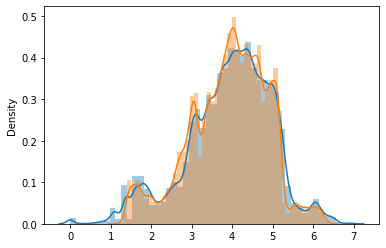

-------------------------------------------------------------
groupNum_train 101 (51636, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 34424 valid 17212
training LGB:
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4394
[LightGBM] [Info] Number of data points in the train set: 34424, number of used features: 34
[LightGBM] [Info] Start training from score 2.907762
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's l2: 1.9046	valid_1's l2: 4.18326
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.9045975001687843)]), 'valid_1': OrderedDict([('l2', 4.183258252000783)])})
[ 1  3  5  6  7  8  9 11]

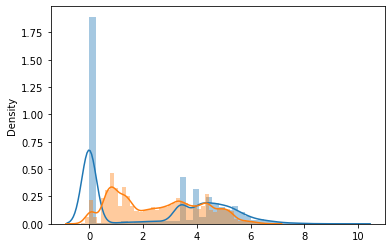

-------------------------------------------------------------
groupNum_train 103 (83138, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 55425 valid 27713
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4438
[LightGBM] [Info] Number of data points in the train set: 55425, number of used features: 34
[LightGBM] [Info] Start training from score 3.071236
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 2.39838	valid_1's l2: 4.66025
Early stopping, best iteration is:
[61]	training's l2: 2.24392	valid_1's l2: 4.62862
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 2.2439241437126016)]), 'valid_1': OrderedDict([('l2', 4.6286212306323335)])})
[ 3  4  5  6  7  8  9 10]
train 55425 valid 27713
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi

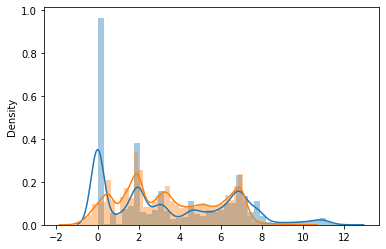

-------------------------------------------------------------
groupNum_train 110 (43400, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 28933 valid 14467
training LGB:
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5263
[LightGBM] [Info] Number of data points in the train set: 28933, number of used features: 30
[LightGBM] [Info] Start training from score 5.394410
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.0207973	valid_1's l2: 0.0239721
[100]	training's l2: 0.0118408	valid_1's l2: 0.0187459
[150]	training's l2: 0.00923991	valid_1's l2: 0.0187524
Early stopping, best iteration is:
[130]	training's l2: 0.0101314	valid_1's l2: 0.0183397
best_score defaultdict(<

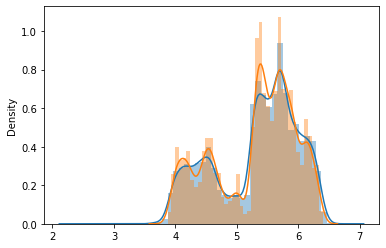

-------------------------------------------------------------
groupNum_train 111 (13954, 38)
cat_features [33, 34, 35, 36, 37]
[1 5 6 7]
train 9302 valid 4652
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4914
[LightGBM] [Info] Number of data points in the train set: 9302, number of used features: 30
[LightGBM] [Info] Start training from score 4.170586
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.56627	valid_1's l2: 3.95242
Early stopping, best iteration is:
[37]	training's l2: 0.72056	valid_1's l2: 3.90323
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.7205601596066737)]), 'valid_1': OrderedDict([('l2', 3.90

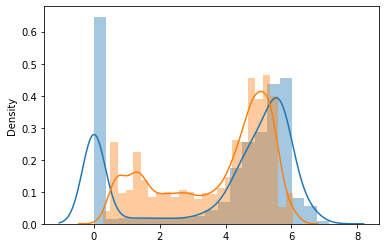

-------------------------------------------------------------
groupNum_train 113 (43403, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 28935 valid 14468
training LGB:
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5263
[LightGBM] [Info] Number of data points in the train set: 28935, number of used features: 30
[LightGBM] [Info] Start training from score 2.721355
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.461439	valid_1's l2: 0.557251
[100]	training's l2: 0.330043	valid_1's l2: 0.468216
[150]	training's l2: 0.28033	valid_1's l2: 0.467344
Early stopping, best iteration is:
[130]	training's l2: 0.297634	valid_1's l2: 0.462559
best_score defaultdict(<class 'col

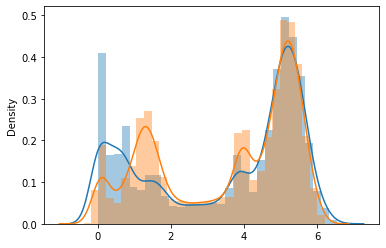

-------------------------------------------------------------
groupNum_train 120 (315772, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5]
train 210514 valid 105258
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4987
[LightGBM] [Info] Number of data points in the train set: 210514, number of used features: 31
[LightGBM] [Info] Start training from score 3.963340
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.158556	valid_1's l2: 0.222951
Early stopping, best iteration is:
[72]	training's l2: 0.132517	valid_1's l2: 0.212817
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.1325173416180375)]), 'valid_1': OrderedDict([('l2', 0.2128174680424165)])})
[5 6 7 8 9]
train 210515 valid 105257
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

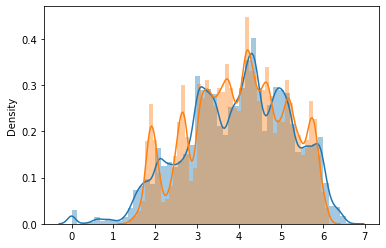

-------------------------------------------------------------
groupNum_train 130 (1210541, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  7  8  9 11]
train 807027 valid 403514
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4954
[LightGBM] [Info] Number of data points in the train set: 807027, number of used features: 34
[LightGBM] [Info] Start training from score 4.656217
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.149419	valid_1's l2: 0.167356
[100]	training's l2: 0.0925851	valid_1's l2: 0.142286
[150]	training's l2: 0.0702514	valid_1's l2: 0.141443
Early stopping, best iteration is:
[137]	training's l2: 0.0749675	valid_1's l2: 0.14005
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict(

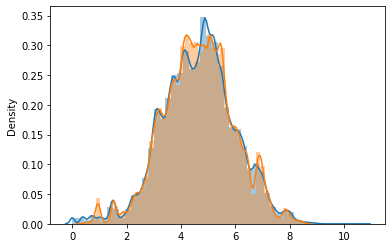

-------------------------------------------------------------
groupNum_train 131 (574174, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  9 10 11]
train 382782 valid 191392
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4768
[LightGBM] [Info] Number of data points in the train set: 382782, number of used features: 34
[LightGBM] [Info] Start training from score 3.987341
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.666912	valid_1's l2: 1.28539
[100]	training's l2: 0.487098	valid_1's l2: 1.18672
Early stopping, best iteration is:
[126]	training's l2: 0.449025	valid_1's l2: 1.17981
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.4490252489039447)]), 'valid_1': OrderedDict([(

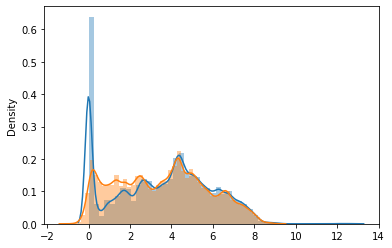

-------------------------------------------------------------
groupNum_train 132 (740199, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 7 8 9]
train 493466 valid 246733
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4836
[LightGBM] [Info] Number of data points in the train set: 493466, number of used features: 34
[LightGBM] [Info] Start training from score 5.939985
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.58925	valid_1's l2: 1.65873
[100]	training's l2: 1.33775	valid_1's l2: 1.52789
[150]	training's l2: 1.20561	valid_1's l2: 1.50832
Early stopping, best iteration is:
[171]	training's l2: 1.16872	valid_1's l2: 1.4981
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.1687184071356

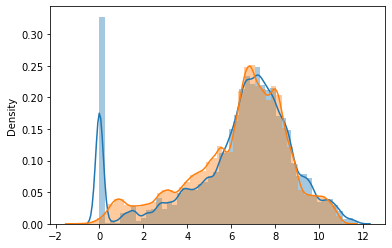

-------------------------------------------------------------
groupNum_train 140 (873333, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7 8]
train 582222 valid 291111
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 582222, number of used features: 34
[LightGBM] [Info] Start training from score 4.534116
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.551594	valid_1's l2: 0.344852
Early stopping, best iteration is:
[49]	training's l2: 0.559226	valid_1's l2: 0.342221
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.5592263125402778)]), 'valid_1': OrderedDict([('l2', 0.34222078795752464)])})
[ 3  4  5  6  7  8  9 10]
train 58

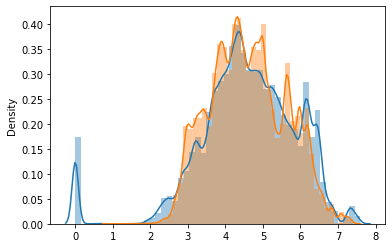

-------------------------------------------------------------
groupNum_train 141 (718263, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 478842 valid 239421
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4612
[LightGBM] [Info] Number of data points in the train set: 478842, number of used features: 34
[LightGBM] [Info] Start training from score 5.605229
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.65021	valid_1's l2: 2.75958
Early stopping, best iteration is:
[69]	training's l2: 1.46361	valid_1's l2: 2.73756
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.463610262082354)]), 'valid_1': OrderedDict([('l2', 2.7375599733404785)])})
[4 5 6 7 8 9]
train 478842 valid 239421
trai

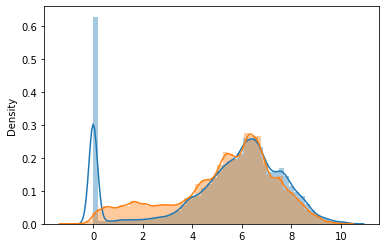

-------------------------------------------------------------
groupNum_train 143 (478463, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 318975 valid 159488
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4550
[LightGBM] [Info] Number of data points in the train set: 318975, number of used features: 34
[LightGBM] [Info] Start training from score 4.215098
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 2.28691	valid_1's l2: 3.57136
[100]	training's l2: 1.97915	valid_1's l2: 3.54492
Early stopping, best iteration is:
[91]	training's l2: 2.01562	valid_1's l2: 3.53471
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 2.0156200892045657)]), 'valid_1': OrderedDict([('l2', 3.534714166770

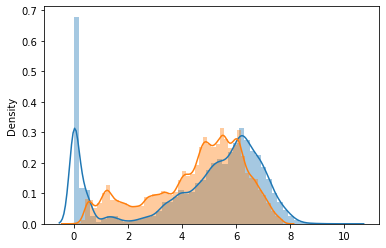

-------------------------------------------------------------
groupNum_train 142 (352906, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6 7]
train 235270 valid 117636
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4514
[LightGBM] [Info] Number of data points in the train set: 235270, number of used features: 34
[LightGBM] [Info] Start training from score 5.628933
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.14257	valid_1's l2: 2.05878
Early stopping, best iteration is:
[41]	training's l2: 1.24818	valid_1's l2: 2.0405
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.2481840894214855)]), 'valid_1': OrderedDict([('l2', 2.0404987170457702)])})
[ 1  4  5  6  7  8  9 10 12]
train 235271 

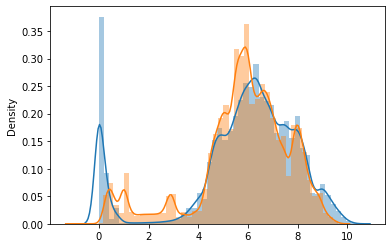

-------------------------------------------------------------
groupNum_train 153 (14797, 38)
cat_features [33, 34, 35, 36, 37]
[1 2 3 4 5 6]
train 9864 valid 4933
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4398
[LightGBM] [Info] Number of data points in the train set: 9864, number of used features: 36
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Start training from score 6.571343
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.161325	valid_1's l2: 0.37787
Early stopping, best iteration is:
[53]	training's l2: 0.154097	valid_1's l2: 0.375507
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.15409746094365462)]), 'valid_1': OrderedDict([('l

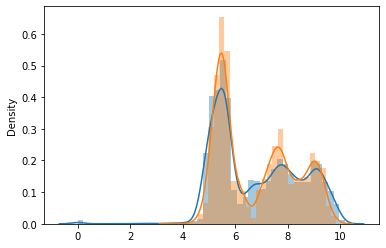

-------------------------------------------------------------
groupNum_train 150 (833085, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  9 10]
train 555390 valid 277695
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4902
[LightGBM] [Info] Number of data points in the train set: 555390, number of used features: 36
[LightGBM] [Info] Start training from score 4.157256
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.0793304	valid_1's l2: 0.113332
[100]	training's l2: 0.0478245	valid_1's l2: 0.0974075
Early stopping, best iteration is:
[110]	training's l2: 0.0444775	valid_1's l2: 0.096971
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.04447746803895012)]), 'valid_1': OrderedDi

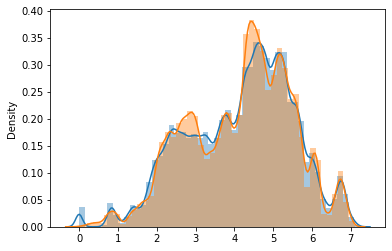

-------------------------------------------------------------
groupNum_train 151 (449642, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7 11 12]
train 299761 valid 149881
training LGB:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4765
[LightGBM] [Info] Number of data points in the train set: 299761, number of used features: 36
[LightGBM] [Info] Start training from score 3.298996
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.218484	valid_1's l2: 0.477883
[100]	training's l2: 0.152814	valid_1's l2: 0.438331
[150]	training's l2: 0.131617	valid_1's l2: 0.433147
[200]	training's l2: 0.119106	valid_1's l2: 0.430627
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.119106	valid_1's l2: 0.430627
best_score defaultdi

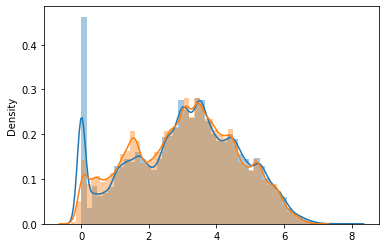

-------------------------------------------------------------
groupNum_train 152 (494111, 38)
cat_features [33, 34, 35, 36, 37]
[ 1  2  3  4  5  6  7  8  9 10 12]
train 329407 valid 164704
training LGB:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4759
[LightGBM] [Info] Number of data points in the train set: 329407, number of used features: 36
[LightGBM] [Info] Start training from score 5.380235
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 0.794569	valid_1's l2: 0.97779
[100]	training's l2: 0.680236	valid_1's l2: 0.945115
[150]	training's l2: 0.639211	valid_1's l2: 0.93802
Early stopping, best iteration is:
[131]	training's l2: 0.64992	valid_1's l2: 0.936572
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.6499202448461163)]), 'valid_1': OrderedDict([('l2', 0.

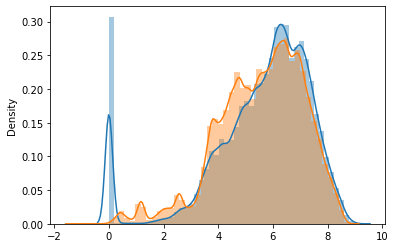

-------------------------------------------------------------


In [69]:
## Traning the Light GBM Model
gc.collect()

for groupNum_train in building_meta_df['groupNum_train'].unique():
    X_train, y_train = create_X_y(train_df, groupNum_train=groupNum_train)
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('groupNum_train', groupNum_train, X_train.shape)

    cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
    print('cat_features', cat_features)

    exec('models' +str(groupNum_train)+ '=[]')

    train_df_site = train_df[train_df['groupNum_train']==groupNum_train].copy()
    
    #for train_idx, valid_idx in kf.split(X_train, y_train):
    #for train_idx, valid_idx in kf.split(X_train, y_train, groups=get_groups(train_df, groupNum_train)):    
    for train_idx, valid_idx in kf.split(train_df_site, train_df_site['building_id']):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        mindex = train_df_site.iloc[valid_idx,:].month.unique()
        print (mindex)

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                            num_rounds=num_rounds, lr=0.05, bf=0.7)
        y_valid_pred_total[valid_idx] = y_pred_valid
        exec('models' +str(groupNum_train)+ '.append([mindex, model])')        
        gc.collect()
        if debug:
            break

    try:
        sns.distplot(y_train)
        sns.distplot(y_valid_pred_total)
        plt.show()
    except:
        pass

    del X_train, y_train
    gc.collect()
    
    print('-------------------------------------------------------------')

In [70]:
# Prediction on test data¶

print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')

print('Before Preprocessing ....')
print('Shape of test data: ', test_df.shape)
print('Shape of Weather test data: ',weather_test_df.shape)

weather_test_df = weather_test_df.drop_duplicates(['timestamp', 'site_id'])
set_local(weather_test_df)
add_holiyday(weather_test_df)

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
#test_df['building_median'] = test_df['building_id'].map(building_median)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(method ='ffill', limit_direction ='forward'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_sg(weather_test_df)

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

#bid_map = train_df.building_id.value_counts()
test_df['bid_cnt'] = test_df.building_id.map(bid_map)

test_df = test_df.merge(building_meta_df[['building_id','meter','groupNum_train']], on=['building_id','meter'], how='left')
              
print('reduce mem usage...')
test_df = reduce_mem_usage(test_df, use_float16=True)
weather_test_df = reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

print('After Preprocessing ....')
print('Shape of test data: ', test_df.shape)
print('Shape of Weather test data: ',weather_test_df.shape)

loading...
Before Preprocessing ....
Shape of test data:  (41697600, 4)
Shape of Weather test data:  (277243, 9)
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 3221.04 MB
Memory usage after optimization is: 1352.06 MB
Decreased by 58.0%
Memory usage of dataframe is 48.12 MB
Memory usage after optimization is: 41.51 MB
Decreased by 13.7%
After Preprocessing ....
Shape of test data:  (41697600, 12)
Shape of Weather test data:  (277243, 72)


In [71]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

print(sample_submission.shape)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%
(41697600, 2)


In [72]:
def create_X(test_df, groupNum_train):
    
    target_test_df = test_df[test_df['groupNum_train'] == groupNum_train].copy()        
    # target_test_df = target_test_df.merge(df_groupNum_median, on=['timestamp'], how='left')
    target_test_df = target_test_df.merge(building_meta_df, on=['building_id','meter','groupNum_train'], how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    # target_test_df['group_median_'+str(groupNum_train)] = np.nan

    X_test = target_test_df[feature_cols + category_cols]
    
    return X_test

In [73]:
def pred_all(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, (mindex, model) in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total


def pred(X_test, models, batch_size=1000000):
    if predmode == 'valid':
        print ('valid pred')
        return pred_valid(X_test, models, batch_size=1000000)
    elif predmode == 'train':
        print ('train pred')
        return pred_train(X_test, models, batch_size=1000000)
    else:
        print ('all pred')
        return pred_all(X_test, models, batch_size=1000000)

groupNum_train:  0
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

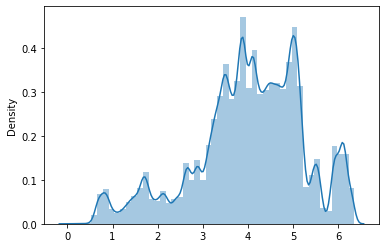

(1839600, 38) (1839600,)
groupNum_train:  1
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

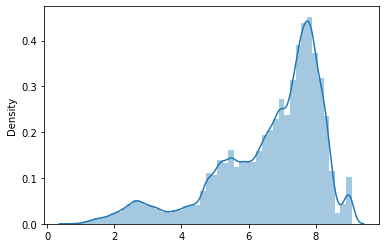

(420480, 38) (420480,)
groupNum_train:  10
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

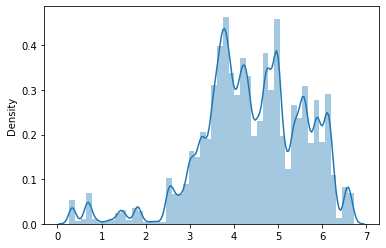

(893520, 38) (893520,)
groupNum_train:  13
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

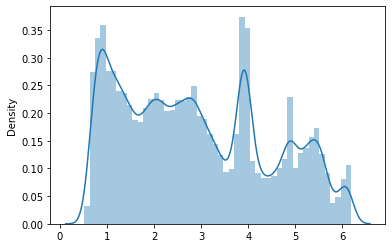

(210240, 38) (210240,)
groupNum_train:  20
all pred
iterations 3
predicting 0-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/3 [00:00<?, ?it/s]

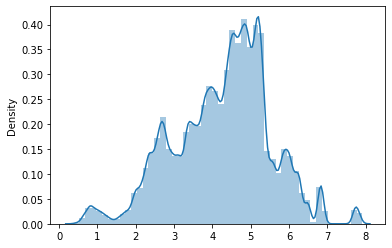

(2365200, 38) (2365200,)
groupNum_train:  21
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

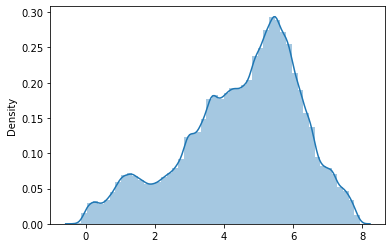

(1734480, 38) (1734480,)
groupNum_train:  23
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

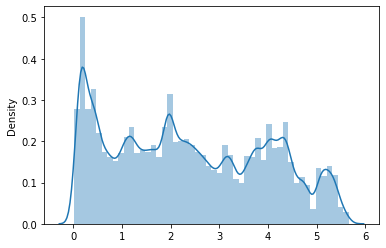

(963600, 38) (963600,)
groupNum_train:  30
all pred
iterations 5
predicting 0-th model


  0%|          | 0/5 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/5 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/5 [00:00<?, ?it/s]

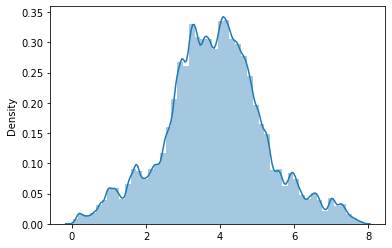

(4800480, 38) (4800480,)
groupNum_train:  40
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

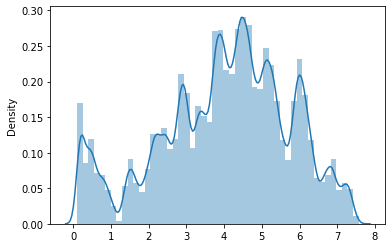

(1594320, 38) (1594320,)
groupNum_train:  50
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

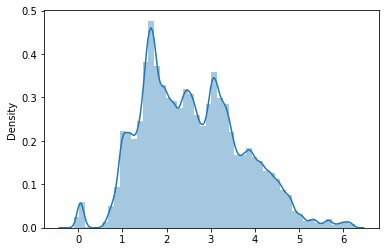

(1559280, 38) (1559280,)
groupNum_train:  60
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

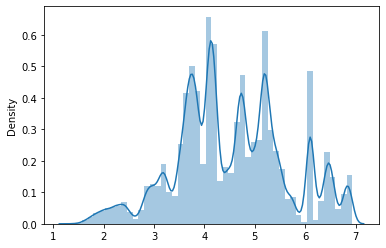

(630720, 38) (630720,)
groupNum_train:  62
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

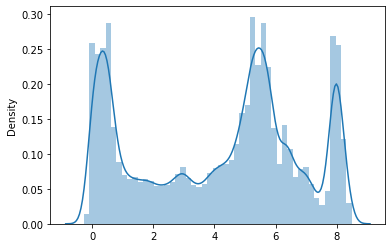

(402960, 38) (402960,)
groupNum_train:  61
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

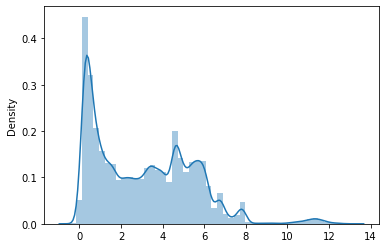

(367920, 38) (367920,)
groupNum_train:  71
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

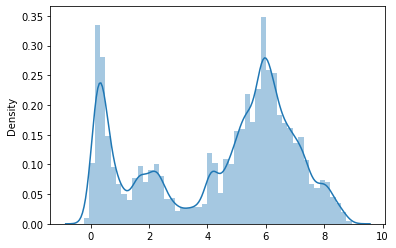

(262800, 38) (262800,)
groupNum_train:  72
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

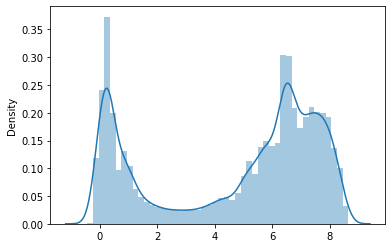

(210240, 38) (210240,)
groupNum_train:  70
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

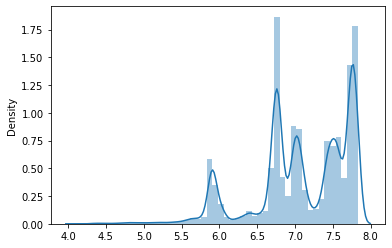

(210240, 38) (210240,)
groupNum_train:  73
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

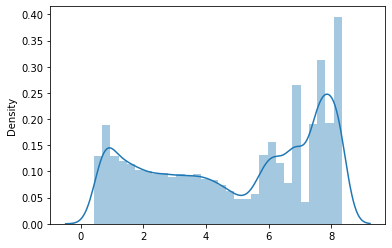

(52560, 38) (52560,)
groupNum_train:  80
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

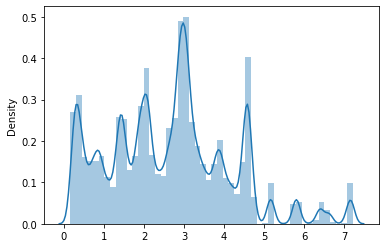

(1226400, 38) (1226400,)
groupNum_train:  90
all pred
iterations 3
predicting 0-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/3 [00:00<?, ?it/s]

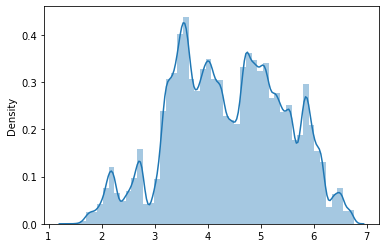

(2137440, 38) (2137440,)
groupNum_train:  91
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

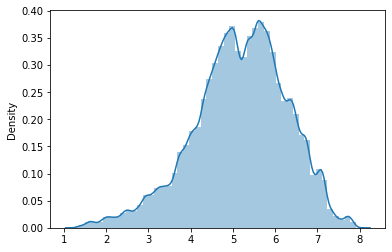

(1664400, 38) (1664400,)
groupNum_train:  92
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

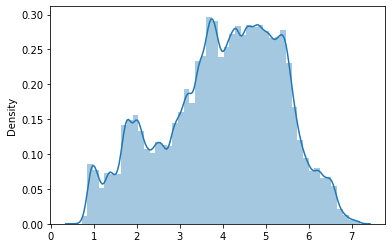

(1559280, 38) (1559280,)
groupNum_train:  100
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

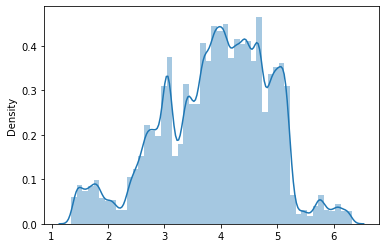

(525600, 38) (525600,)
groupNum_train:  101
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

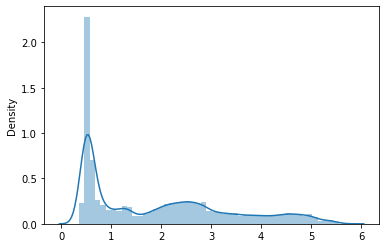

(157680, 38) (157680,)
groupNum_train:  103
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

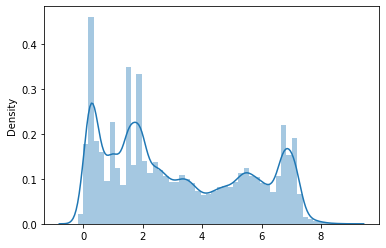

(192720, 38) (192720,)
groupNum_train:  110
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

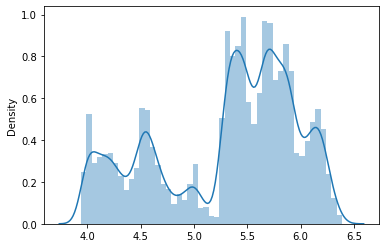

(87600, 38) (87600,)
groupNum_train:  111
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

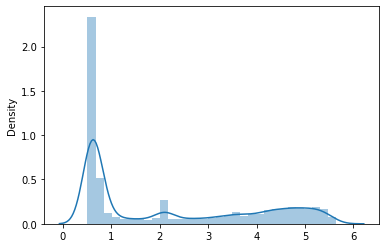

(70080, 38) (70080,)
groupNum_train:  113
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

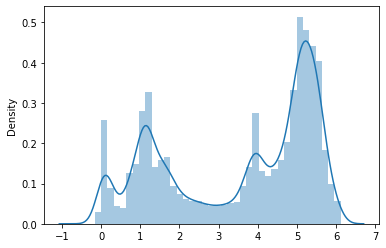

(87600, 38) (87600,)
groupNum_train:  120
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

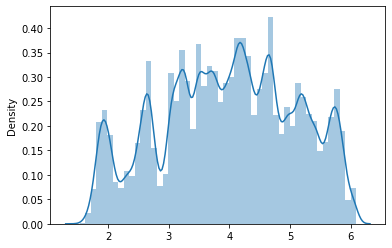

(630720, 38) (630720,)
groupNum_train:  130
all pred
iterations 3
predicting 0-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/3 [00:00<?, ?it/s]

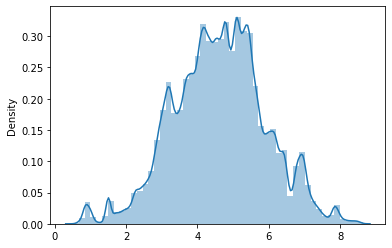

(2470320, 38) (2470320,)
groupNum_train:  131
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

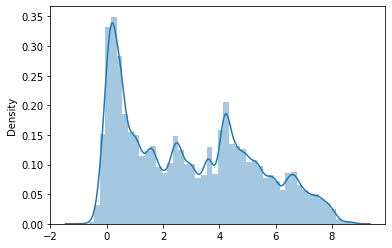

(1401600, 38) (1401600,)
groupNum_train:  132
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

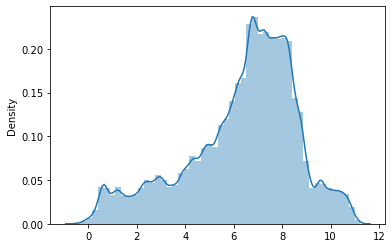

(1541760, 38) (1541760,)
groupNum_train:  140
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

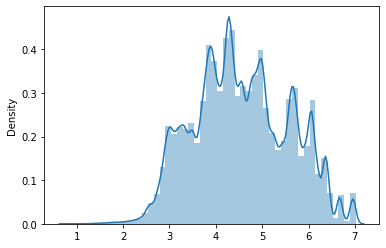

(1787040, 38) (1787040,)
groupNum_train:  141
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

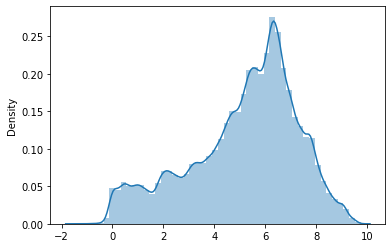

(1506720, 38) (1506720,)
groupNum_train:  143
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

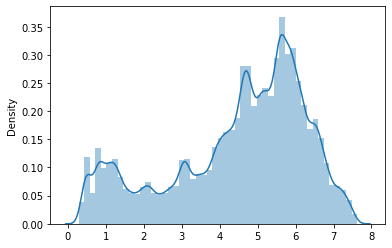

(998640, 38) (998640,)
groupNum_train:  142
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

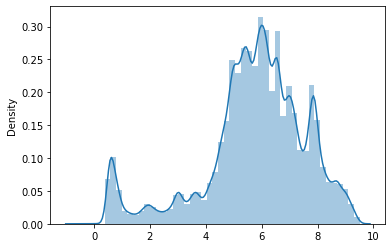

(753360, 38) (753360,)
groupNum_train:  153
all pred
iterations 1
predicting 0-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/1 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/1 [00:00<?, ?it/s]

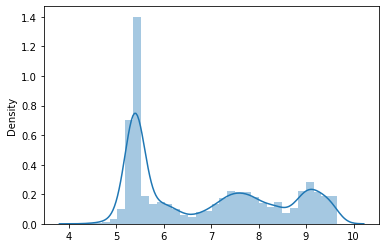

(35040, 38) (35040,)
groupNum_train:  150
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

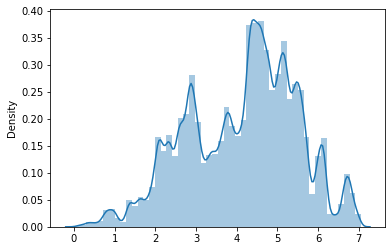

(1997280, 38) (1997280,)
groupNum_train:  151
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

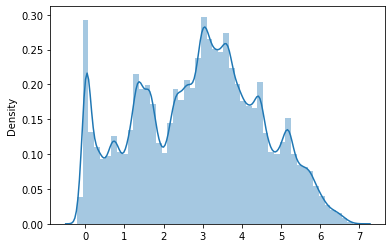

(1138800, 38) (1138800,)
groupNum_train:  152
all pred
iterations 2
predicting 0-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/2 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/2 [00:00<?, ?it/s]

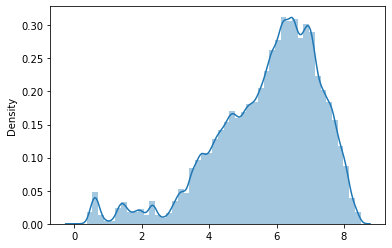

(1208880, 38) (1208880,)


In [74]:
for groupNum_train in building_meta_df['groupNum_train'].unique():
    print('groupNum_train: ', groupNum_train)
    X_test = create_X(test_df, groupNum_train=groupNum_train)
    gc.collect()

    exec('y_test= pred(X_test, models' +str(groupNum_train)+ ')')

    sns.distplot(y_test)
    plt.show()

    print(X_test.shape, y_test.shape)
    sample_submission.loc[test_df["groupNum_train"] == groupNum_train,"meter_reading"] = np.expm1(y_test)
    
    del X_test, y_test
    gc.collect()

In [75]:
# Exporting Test data, building metadata, and weather data after preprocessing 
# To be used in other models.
test_df.to_feather('test_df_processed.feather')
weather_test_df.to_feather('weather_test_df_processed.feather')
building_meta_df.to_feather('building_meta_df_processed.feather')

In [76]:
test_df.shape


(41697600, 12)

In [77]:
weather_test_df.shape


(277243, 72)

In [78]:
building_meta_df.shape

(2380, 10)

In [79]:
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
sample_submission.loc[(test_df.building_id.isin(site_0_bids)) & (test_df.meter==0), 'meter_reading'] = sample_submission[(test_df.building_id.isin(site_0_bids)) & (test_df.meter==0)]['meter_reading'] * 3.4118

In [80]:
# https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261#latest-684102
sample_submission.loc[(test_df.building_id.isin(site_0_bids)) & (test_df.meter==0), 'meter_reading'] = sample_submission[(test_df.building_id.isin(site_0_bids)) & (test_df.meter==0)]['meter_reading'] * 3.4118

In [81]:
if rescale:   
    sample_submission.loc[(test_df.building_id == 778) & (test_df.meter == 1), 'meter_reading'] = 100 * sample_submission.loc[(test_df.building_id == 778) & (test_df.meter == 1), 'meter_reading']
    sample_submission.loc[(test_df.building_id == 1021) & (test_df.meter == 3), 'meter_reading'] = 1000 * sample_submission.loc[(test_df.building_id == 1021) & (test_df.meter == 3), 'meter_reading']
    
    plt.figure()
    plt.subplot(211)
    sample_submission.loc[(test_df.building_id == 778) & (test_df.meter == 1), 'meter_reading'].plot()
    plt.subplot(212)    
    sample_submission.loc[(test_df.building_id == 1021) & (test_df.meter == 3), 'meter_reading'].plot()

In [82]:
sample_submission.head()

,row_id,meter_reading
0,0,714.287055
1,1,326.730024
2,2,33.405868
3,3,1117.102053
4,4,4834.299951


In [83]:
sample_submission.tail()

,row_id,meter_reading
41697595,41697595,6.758634
41697596,41697596,4.645618
41697597,41697597,5.845237
41697598,41697598,162.970555
41697599,41697599,3.819055


In [84]:
print('Shape of Sample Submission', sample_submission.shape)

Shape of Sample Submission (41697600, 2)


In [85]:
if not debug:
    sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

<AxesSubplot:>

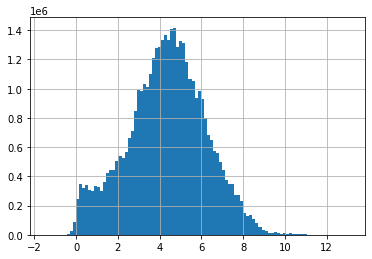

In [86]:
np.log1p(sample_submission['meter_reading']).hist(bins=100)